# CS 4993 Independent Study – Machine Learning with COVID Data

***Professor: [Haiyang Shen](https://engineering.virginia.edu/faculty/haiying-shen)***  
***Researcher: [Iain Muir](https://www.linkedin.com/in/iain-muir-b37718164/) | iam9ez***

*Github Project:* https://github.com/iainmuir6/machineLearning_covidData

*Last Updated: June 2nd, 2021*

References
* [CS 4774 ML Material – Professor Rich Nguyen](https://www.cs.virginia.edu/~nn4pj/teaching)
* [Steps to Building Machine Learning Model](https://analyticsindiamag.com/the-7-key-steps-to-build-your-machine-learning-model/)
* [Steps to Data Preprocessing](https://hackernoon.com/what-steps-should-one-take-while-doing-data-preprocessing-502c993e1caa)
* [Handling Missing Values](https://towardsdatascience.com/7-ways-to-handle-missing-values-in-machine-learning-1a6326adf79e)
* [Feature Selection I](https://towardsdatascience.com/the-5-feature-selection-algorithms-every-data-scientist-need-to-know-3a6b566efd2)
* [Feature Selection II](https://machinelearningmastery.com/feature-selection-machine-learning-python/)
* [Keras Neural Network I](https://towardsdatascience.com/3-ways-to-create-a-machine-learning-model-with-keras-and-tensorflow-2-0-de09323af4d3)

## 0. Import Packages

#### 0.1 General Imports

In [174]:
import matplotlib.pyplot as plt
from matplotlib import cm
import missingno as msno
import seaborn as sns
import pandas as pd
import numpy as np
import random

#### 0.2 ML Imports

In [173]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2, RFE, SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from keras.models import Sequential
from keras.layers import Dense
from tensorflow import keras
import tensorflow as tf

In [123]:
tf.__version__

'2.3.0'

In [121]:
keras.__version__

'2.4.0'

## 1. Read Excel File

#### 1.1 Data Overview

In [44]:
df = pd.read_excel('ed_pred.xlsx')
df = df.reset_index()
df.head(5)

,index,patno,Admitted,AdmittingDepartment,COVIDResult,Age,FirstRace,Ethnicity,Sex,heart_rate,...,cmp_bicarbonate,cmp_bun,cmp_creatinine,cmp_glucose,cmp_alt,cmp_ast,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin,cmp_bilirubin
0,0,1,1,UVHE MICU,None Detected,78,White or Caucasian,Non-Hispanic,Female,94.0,...,26,31,2.5,82.0,14,26.0,80.0,8.5,4.3,0.5
1,1,2,0,NaN,None Detected,23,White or Caucasian,Non-Hispanic,Female,121.0,...,19,11,0.9,83.0,73,NaN,100.0,8.1,4.6,0.6
2,2,3,0,NaN,None Detected,55,African American,Non-Hispanic,Male,83.0,...,23,9,1.2,123.0,26,29.0,106.0,7.1,4.0,0.7
3,3,4,1,UVHE MICU,None Detected,50,White or Caucasian,Non-Hispanic,Male,88.0,...,30,45,1.6,297.0,22,NaN,78.0,7.8,3.7,0.5
4,4,5,0,NaN,None Detected,67,African American,Non-Hispanic,Female,90.0,...,27,25,1.0,96.0,12,18.0,122.0,7.4,3.5,0.2


In [45]:
df.shape

(7380, 41)

In [46]:
target = 'COVIDResult'
df.columns

Index(['index', 'patno', 'Admitted', 'AdmittingDepartment', 'COVIDResult',
       'Age', 'FirstRace', 'Ethnicity', 'Sex', 'heart_rate', 'sbp', 'dbp',
       'pulse_ox', 'resp_rate', 'height', 'wght', 'cbc_wbc', 'cbc_hematocrit',
       'cbc_hemoglobin', 'cbc_platelets', 'cbc_neutrophil_c',
       'cbc_eosinophil_perc', 'cbc_lymphocyte_c', 'cbc_lymphocyte_perc',
       'cbc_eosinophil_c', 'cbc_eosinophil_perc.1', 'cbc_monocyte_c',
       'cbc_eosinophil_perc.2', 'cmp_sodium', 'cmp_potassium', 'cmp_chloride',
       'cmp_bicarbonate', 'cmp_bun', 'cmp_creatinine', 'cmp_glucose',
       'cmp_alt', 'cmp_ast', 'cmp_alkaline_phosphatase', 'cmp_total_protein',
       'cmp_albumin', 'cmp_bilirubin'],
      dtype='object')

###### Column Description
Note (src - [Walk-In-Lab](https://www.walkinlab.com/products/view/complete-blood-count-cbc-comprehensive-metabolic-panel-cmp-14-blood-test-panel#:~:text=A%20CBC%20also%20helps%20your,anemia%2C%20and%20several%20other%20disorders.&text=Comprehensive%20Metabolic%20Panel%20(CMP%2D14)%20with%20eGFR%20is%20a,electrolyte%20and%20acid%2Fbase%20balance.)): 

CBC == [Complete Blood Count](https://www.mayoclinic.org/tests-procedures/complete-blood-count/about/pac-20384919)
* Complete Blood Count (CBC) gives important information about the numbers and kinds of cells in the blood, especially red blood cells, white blood cells, and platelets. A CBC helps your health professional check any symptoms, such as fatigue, weakness, or bruising, that you may have. A CBC also helps your health professional diagnose conditions, such as infection, anemia, and several other disorders.

CMP == [Comprehensive Metabolic Panel](https://www.mayocliniclabs.com/test-catalog/Clinical+and+Interpretive/113631)
* Comprehensive Metabolic Panel (CMP-14) with eGFR is a group of 14 laboratory tests ordered to give information about the current status of your liver, kidneys, and electrolyte and acid/base balance.  The test gives the current status of your blood sugar and blood proteins also.

Output
* COVIDResult: Detected / None Detected
Inputs
* heart_rate
* sbp
* dbp
* pulse_ox
* resp_rate

In [47]:
df.index

RangeIndex(start=0, stop=7380, step=1)

#### 1.2 Descriptive Statistics

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7380 entries, 0 to 7379
Data columns (total 41 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   index                     7380 non-null   int64  
 1   patno                     7380 non-null   int64  
 2   Admitted                  7380 non-null   int64  
 3   AdmittingDepartment       3003 non-null   object 
 4   COVIDResult               7380 non-null   object 
 5   Age                       7380 non-null   int64  
 6   FirstRace                 7379 non-null   object 
 7   Ethnicity                 7380 non-null   object 
 8   Sex                       7380 non-null   object 
 9   heart_rate                7352 non-null   float64
 10  sbp                       7292 non-null   float64
 11  dbp                       7292 non-null   float64
 12  pulse_ox                  7346 non-null   float64
 13  resp_rate                 7312 non-null   float64
 14  height  

In [49]:
df.describe()

,index,patno,Admitted,Age,heart_rate,sbp,dbp,pulse_ox,resp_rate,height,...,cbc_monocyte_c,cbc_eosinophil_perc.2,cmp_sodium,cmp_potassium,cmp_chloride,cmp_glucose,cmp_ast,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin
count,7380.000000,7380.000000,7380.000000,7380.000000,7352.000000,7292.000000,7292.000000,7346.000000,7312.000000,456.000000,...,3874.000000,3872.000000,6286.000000,5570.000000,6286.000000,6286.000000,4767.000000,5399.000000,5175.000000,5402.000000
mean,3689.500000,3690.500000,0.406911,48.977642,94.529788,135.998354,76.034696,97.064661,21.029130,65.971491,...,0.740428,1.492485,137.104677,4.043447,102.562997,137.406141,55.627858,114.154843,7.210473,3.846113
std,2130.566826,2130.566826,0.491291,23.525661,23.352438,27.256409,15.302797,3.832935,6.762566,7.635750,...,0.545253,2.276703,4.366669,0.603037,5.600923,92.857337,154.142598,89.983238,0.843891,0.577974
min,0.000000,1.000000,0.000000,0.000000,0.000000,46.000000,0.000000,25.000000,0.000000,2.000000,...,0.000000,0.000000,107.000000,2.000000,60.000000,22.000000,7.000000,21.000000,2.400000,1.000000
25%,1844.750000,1845.750000,0.000000,31.000000,78.000000,118.000000,65.000000,96.000000,18.000000,63.000000,...,0.460000,0.100000,135.000000,3.700000,100.000000,94.000000,23.000000,71.000000,6.700000,3.500000
50%,3689.500000,3690.500000,0.000000,52.000000,92.000000,133.000000,75.000000,98.000000,20.000000,67.000000,...,0.670000,0.800000,138.000000,4.000000,103.000000,109.000000,31.000000,90.000000,7.200000,3.900000
75%,5534.250000,5535.250000,1.000000,67.000000,107.000000,151.000000,86.000000,99.000000,22.000000,70.000000,...,0.940000,2.000000,140.000000,4.300000,106.000000,140.000000,46.000000,123.000000,7.700000,4.200000
max,7379.000000,7380.000000,1.000000,119.000000,235.000000,258.000000,147.000000,100.000000,111.000000,77.000000,...,17.790000,41.100000,182.000000,8.900000,143.000000,1576.000000,6479.000000,1126.000000,11.300000,6.300000


In [50]:
df.corr()

,index,patno,Admitted,Age,heart_rate,sbp,dbp,pulse_ox,resp_rate,height,...,cbc_monocyte_c,cbc_eosinophil_perc.2,cmp_sodium,cmp_potassium,cmp_chloride,cmp_glucose,cmp_ast,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin
index,1.000000,1.000000,-0.030377,-0.071132,-0.014543,-0.013479,-0.002088,0.066634,-0.031710,-0.017314,...,0.006011,0.000322,0.039232,-0.005859,0.026758,-0.010492,-0.036648,-0.011070,0.016393,0.045855
patno,1.000000,1.000000,-0.030377,-0.071132,-0.014543,-0.013479,-0.002088,0.066634,-0.031710,-0.017314,...,0.006011,0.000322,0.039232,-0.005859,0.026758,-0.010492,-0.036648,-0.011070,0.016393,0.045855
Admitted,-0.030377,-0.030377,1.000000,0.259000,0.071533,-0.034520,-0.083964,-0.187805,0.141345,0.006556,...,0.090950,-0.122416,-0.139857,0.123330,-0.145144,0.125331,0.098732,0.117501,-0.169298,-0.301735
Age,-0.071132,-0.071132,0.259000,1.000000,-0.343054,0.255632,0.021500,-0.233759,-0.128765,0.237857,...,-0.068070,-0.003148,-0.077553,0.129890,-0.137116,0.097948,-0.014016,-0.091849,-0.147716,-0.312481
heart_rate,-0.014543,-0.014543,0.071533,-0.343054,1.000000,-0.128325,0.032385,-0.018398,0.397967,-0.277916,...,0.100502,-0.102094,-0.062122,-0.048065,-0.073826,0.074114,0.025044,0.123586,0.046071,0.021046
sbp,-0.013479,-0.013479,-0.034520,0.255632,-0.128325,1.000000,0.700990,0.012399,-0.054224,0.129512,...,-0.037211,0.056011,0.089829,-0.016583,0.003022,0.052785,-0.058817,-0.102502,0.195652,0.193473
dbp,-0.002088,-0.002088,-0.083964,0.021500,0.032385,0.700990,1.000000,0.044760,-0.038692,0.178501,...,-0.019228,0.026571,0.119920,-0.055991,0.036059,0.017755,-0.010922,-0.091883,0.268447,0.288271
pulse_ox,0.066634,0.066634,-0.187805,-0.233759,-0.018398,0.012399,0.044760,1.000000,-0.203094,0.003070,...,-0.002565,0.017027,0.012110,-0.118440,0.099202,-0.105208,-0.052456,-0.005379,0.037321,0.123265
resp_rate,-0.031710,-0.031710,0.141345,-0.128765,0.397967,-0.054224,-0.038692,-0.203094,1.000000,-0.339655,...,0.078115,-0.037053,-0.013692,0.118477,-0.008239,0.076232,0.037055,0.099776,-0.078270,-0.083926
height,-0.017314,-0.017314,0.006556,0.237857,-0.277916,0.129512,0.178501,0.003070,-0.339655,1.000000,...,-0.033168,-0.156211,0.055314,-0.173582,0.030194,0.057657,0.005574,-0.187236,0.127008,0.030490


In [51]:
# pos = df.loc[df['COVIDResult'] == 'Detected']
# print('Number of Positive Patients:', len(pos))
# neg = df.loc[df['COVIDResult'] == 'None Detected']
# print('Number of Negative Patients:', len(neg))
# neither = neg = df.loc[(df['COVIDResult'] != 'None Detected') & (df['COVIDResult'] != 'Detected')]
# print('Number of Inconculsive Data Points:', len(neither))

print(df[target].value_counts())

None Detected    6910
Detected          470
Name: COVIDResult, dtype: int64


#### 1.3 Inspect Null Data

In [52]:
print('Total Number of NULL Data Points:', df.isnull().sum().sum())
df.isnull().sum()

Total Number of NULL Data Points: 69411


index                          0
patno                          0
Admitted                       0
AdmittingDepartment         4377
COVIDResult                    0
Age                            0
FirstRace                      1
Ethnicity                      0
Sex                            0
heart_rate                    28
sbp                           88
dbp                           88
pulse_ox                      34
resp_rate                     68
height                      6924
wght                        4132
cbc_wbc                     1124
cbc_hematocrit              1124
cbc_hemoglobin              1123
cbc_platelets               1124
cbc_neutrophil_c            3507
cbc_eosinophil_perc         3508
cbc_lymphocyte_c            3506
cbc_lymphocyte_perc         3506
cbc_eosinophil_c            3508
cbc_eosinophil_perc.1       3508
cbc_monocyte_c              3506
cbc_eosinophil_perc.2       3508
cmp_sodium                  1094
cmp_potassium               1810
cmp_chlori

In [53]:
d = {
    col: round(df[col].isnull().sum() * 100 / len(df[col]), 4)
    for col in df
}
d = dict(sorted(d.items(), key=lambda item: item[1], reverse=True))
majority_null = [k for k, v in d.items() if v > 50.0]

# print("Null Data Points by variable")
# d

<AxesSubplot:>

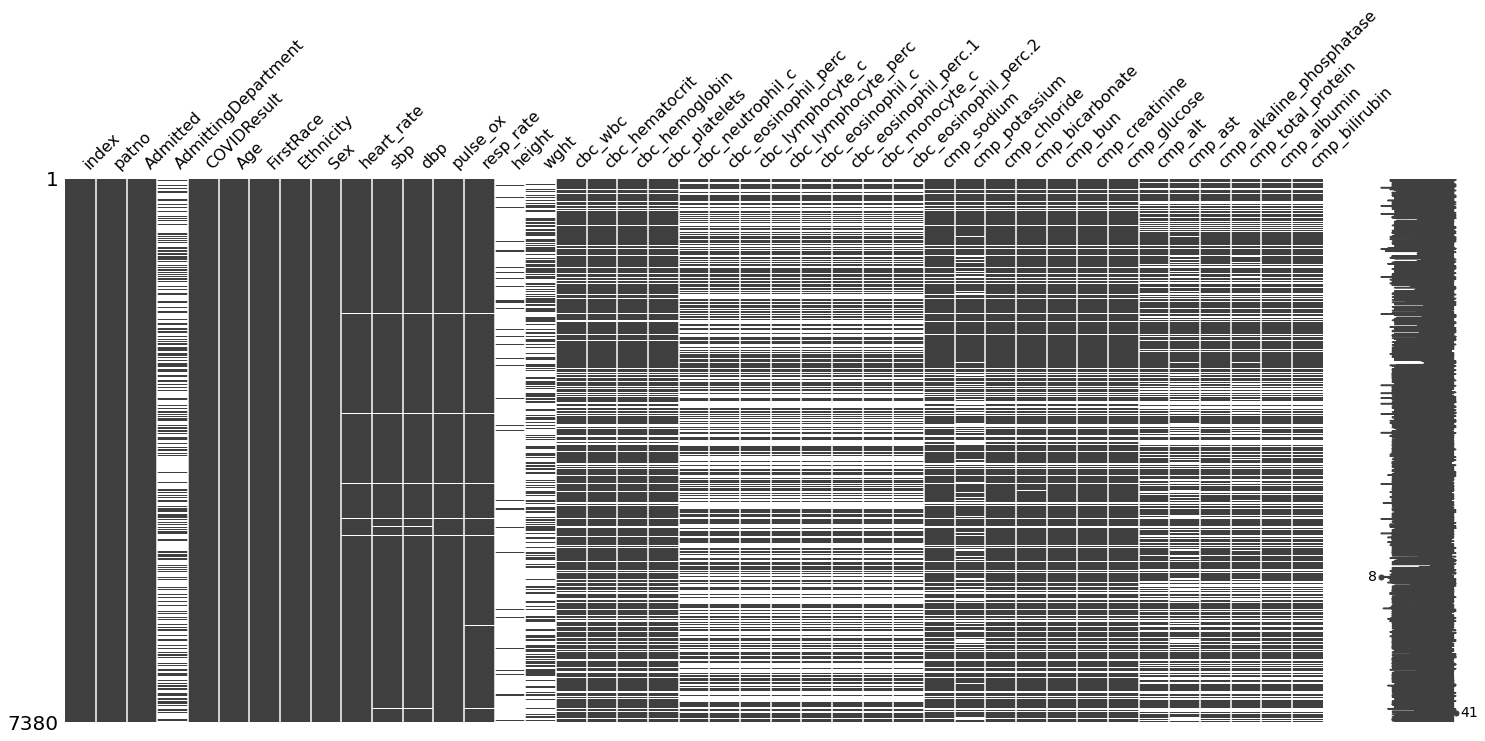

In [54]:
msno.matrix(df)
# msno.heatmap(df)

## 2. Data Preparation

#### 2.1 Drop Columns

In [55]:
trim_df = df.drop(columns=majority_null)
trim_df = trim_df.drop(columns=['index', 'patno'])
trim_df.head(5)

,Admitted,COVIDResult,Age,FirstRace,Ethnicity,Sex,heart_rate,sbp,dbp,pulse_ox,...,cmp_bicarbonate,cmp_bun,cmp_creatinine,cmp_glucose,cmp_alt,cmp_ast,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin,cmp_bilirubin
0,1,None Detected,78,White or Caucasian,Non-Hispanic,Female,94.0,138.0,82.0,96.0,...,26,31,2.5,82.0,14,26.0,80.0,8.5,4.3,0.5
1,0,None Detected,23,White or Caucasian,Non-Hispanic,Female,121.0,134.0,88.0,98.0,...,19,11,0.9,83.0,73,NaN,100.0,8.1,4.6,0.6
2,0,None Detected,55,African American,Non-Hispanic,Male,83.0,152.0,76.0,98.0,...,23,9,1.2,123.0,26,29.0,106.0,7.1,4.0,0.7
3,1,None Detected,50,White or Caucasian,Non-Hispanic,Male,88.0,138.0,65.0,87.0,...,30,45,1.6,297.0,22,NaN,78.0,7.8,3.7,0.5
4,0,None Detected,67,African American,Non-Hispanic,Female,90.0,128.0,69.0,98.0,...,27,25,1.0,96.0,12,18.0,122.0,7.4,3.5,0.2


In [56]:
trim_df.isnull().sum().sum()

53978

#### 2.2 Handle Categorical Variables

In [57]:
trim_df.select_dtypes(include=['object']).columns

Index(['COVIDResult', 'FirstRace', 'Ethnicity', 'Sex', 'cmp_bicarbonate',
       'cmp_bun', 'cmp_creatinine', 'cmp_alt', 'cmp_bilirubin'],
      dtype='object')

###### 2.2.1 Manual Conversion

In [58]:
cat_cols = [
    'cmp_bicarbonate', 'cmp_bun', 'cmp_creatinine', 'cmp_alt', 'cmp_bilirubin'
]
less_than_list = [
    '<5', '<2', '<0.2', '<6', '<0.1'
]


def replace_cat(val, less, num):
    if val == less:
        return random.uniform(0, num) if "." in less else random.randint(0, num)
    else:
        return float(val)

    
trim_df2 = trim_df.copy()
for col, less_than in zip(cat_cols, less_than_list):
    upper_range = float(less_than[1:])
    trim_df2[col] = trim_df2[col].apply(lambda x: replace_cat(x, less_than, upper_range))

trim_df2.head(5)

,Admitted,COVIDResult,Age,FirstRace,Ethnicity,Sex,heart_rate,sbp,dbp,pulse_ox,...,cmp_bicarbonate,cmp_bun,cmp_creatinine,cmp_glucose,cmp_alt,cmp_ast,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin,cmp_bilirubin
0,1,None Detected,78,White or Caucasian,Non-Hispanic,Female,94.0,138.0,82.0,96.0,...,26.0,31.0,2.5,82.0,14.0,26.0,80.0,8.5,4.3,0.5
1,0,None Detected,23,White or Caucasian,Non-Hispanic,Female,121.0,134.0,88.0,98.0,...,19.0,11.0,0.9,83.0,73.0,NaN,100.0,8.1,4.6,0.6
2,0,None Detected,55,African American,Non-Hispanic,Male,83.0,152.0,76.0,98.0,...,23.0,9.0,1.2,123.0,26.0,29.0,106.0,7.1,4.0,0.7
3,1,None Detected,50,White or Caucasian,Non-Hispanic,Male,88.0,138.0,65.0,87.0,...,30.0,45.0,1.6,297.0,22.0,NaN,78.0,7.8,3.7,0.5
4,0,None Detected,67,African American,Non-Hispanic,Female,90.0,128.0,69.0,98.0,...,27.0,25.0,1.0,96.0,12.0,18.0,122.0,7.4,3.5,0.2


In [59]:
trim_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7380 entries, 0 to 7379
Data columns (total 36 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Admitted                  7380 non-null   int64  
 1   COVIDResult               7380 non-null   object 
 2   Age                       7380 non-null   int64  
 3   FirstRace                 7379 non-null   object 
 4   Ethnicity                 7380 non-null   object 
 5   Sex                       7380 non-null   object 
 6   heart_rate                7352 non-null   float64
 7   sbp                       7292 non-null   float64
 8   dbp                       7292 non-null   float64
 9   pulse_ox                  7346 non-null   float64
 10  resp_rate                 7312 non-null   float64
 11  cbc_wbc                   6256 non-null   float64
 12  cbc_hematocrit            6256 non-null   float64
 13  cbc_hemoglobin            6257 non-null   float64
 14  cbc_plat

#### 2.2.2 Encoding

In [60]:
cat_cols = [
    'COVIDResult', 'FirstRace', 'Ethnicity', 'Sex'
]

trim_df3 = trim_df2.copy()
for col in cat_cols:
    trim_df3[col] = trim_df3[col].fillna("Unspecified")
    enc = OrdinalEncoder()
    trim_df3[col + "_Encoded"] = enc.fit_transform(trim_df3[[col]])
trim_df3.head(5)

,Admitted,COVIDResult,Age,FirstRace,Ethnicity,Sex,heart_rate,sbp,dbp,pulse_ox,...,cmp_alt,cmp_ast,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin,cmp_bilirubin,COVIDResult_Encoded,FirstRace_Encoded,Ethnicity_Encoded,Sex_Encoded
0,1,None Detected,78,White or Caucasian,Non-Hispanic,Female,94.0,138.0,82.0,96.0,...,14.0,26.0,80.0,8.5,4.3,0.5,1.0,9.0,2.0,0.0
1,0,None Detected,23,White or Caucasian,Non-Hispanic,Female,121.0,134.0,88.0,98.0,...,73.0,NaN,100.0,8.1,4.6,0.6,1.0,9.0,2.0,0.0
2,0,None Detected,55,African American,Non-Hispanic,Male,83.0,152.0,76.0,98.0,...,26.0,29.0,106.0,7.1,4.0,0.7,1.0,0.0,2.0,1.0
3,1,None Detected,50,White or Caucasian,Non-Hispanic,Male,88.0,138.0,65.0,87.0,...,22.0,NaN,78.0,7.8,3.7,0.5,1.0,9.0,2.0,1.0
4,0,None Detected,67,African American,Non-Hispanic,Female,90.0,128.0,69.0,98.0,...,12.0,18.0,122.0,7.4,3.5,0.2,1.0,0.0,2.0,0.0


###### Categorical Codes

In [61]:
for col in cat_cols:
    print(col)
    for each in trim_df3.groupby([col, col + '_Encoded']).indices:
        print(each)
    print()

COVIDResult
('Detected', 0.0)
('None Detected', 1.0)

FirstRace
('African American', 0.0)
('American Indian and Alaska Native', 1.0)
('Asian', 2.0)
('Hispanic', 3.0)
('Native Hawaiian and Other Pacific Islander', 4.0)
('Other', 5.0)
('Patient Refused', 6.0)
('Patient Unavailable', 7.0)
('Unspecified', 8.0)
('White or Caucasian', 9.0)

Ethnicity
('*Unspecified', 0.0)
('Hispanic', 1.0)
('Non-Hispanic', 2.0)
('Patient Refused', 3.0)
('Patient Unavailable', 4.0)

Sex
('Female', 0.0)
('Male', 1.0)
('Unknown', 2.0)



In [62]:
trim_df3 = trim_df3.drop(columns=['COVIDResult', 'FirstRace', 'Ethnicity', 'Sex'])
trim_df3.head(5)

,Admitted,Age,heart_rate,sbp,dbp,pulse_ox,resp_rate,cbc_wbc,cbc_hematocrit,cbc_hemoglobin,...,cmp_alt,cmp_ast,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin,cmp_bilirubin,COVIDResult_Encoded,FirstRace_Encoded,Ethnicity_Encoded,Sex_Encoded
0,1,78,94.0,138.0,82.0,96.0,29.0,14.01,34.1,11.0,...,14.0,26.0,80.0,8.5,4.3,0.5,1.0,9.0,2.0,0.0
1,0,23,121.0,134.0,88.0,98.0,18.0,5.04,36.2,11.9,...,73.0,NaN,100.0,8.1,4.6,0.6,1.0,9.0,2.0,0.0
2,0,55,83.0,152.0,76.0,98.0,21.0,7.13,36.0,12.0,...,26.0,29.0,106.0,7.1,4.0,0.7,1.0,0.0,2.0,1.0
3,1,50,88.0,138.0,65.0,87.0,18.0,5.74,32.9,11.6,...,22.0,NaN,78.0,7.8,3.7,0.5,1.0,9.0,2.0,1.0
4,0,67,90.0,128.0,69.0,98.0,18.0,10.56,31.7,9.8,...,12.0,18.0,122.0,7.4,3.5,0.2,1.0,0.0,2.0,0.0


In [63]:
trim_df3.shape

(7380, 36)

In [64]:
trim_df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7380 entries, 0 to 7379
Data columns (total 36 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Admitted                  7380 non-null   int64  
 1   Age                       7380 non-null   int64  
 2   heart_rate                7352 non-null   float64
 3   sbp                       7292 non-null   float64
 4   dbp                       7292 non-null   float64
 5   pulse_ox                  7346 non-null   float64
 6   resp_rate                 7312 non-null   float64
 7   cbc_wbc                   6256 non-null   float64
 8   cbc_hematocrit            6256 non-null   float64
 9   cbc_hemoglobin            6257 non-null   float64
 10  cbc_platelets             6256 non-null   float64
 11  cbc_neutrophil_c          3873 non-null   float64
 12  cbc_eosinophil_perc       3872 non-null   float64
 13  cbc_lymphocyte_c          3874 non-null   float64
 14  cbc_lymp

#### 2.3 Handle Missing Values

In [65]:
num_cols = [
    'heart_rate', 'sbp', 'dbp', 'pulse_ox', 'resp_rate', 'cbc_wbc', 'cbc_hematocrit', 'cbc_hemoglobin',
    'cbc_platelets', 'cbc_neutrophil_c', 'cbc_eosinophil_perc', 'cbc_lymphocyte_c',
    'cbc_lymphocyte_perc', 'cbc_eosinophil_c', 'cbc_eosinophil_perc.1', 'cbc_monocyte_c',
    'cbc_eosinophil_perc.2', 'cmp_sodium', 'cmp_potassium', 'cmp_chloride', 'cmp_bicarbonate',
    'cmp_bun', 'cmp_creatinine', 'cmp_glucose', 'cmp_alt', 'cmp_ast', 'cmp_alkaline_phosphatase',
    'cmp_total_protein', 'cmp_albumin', 'cmp_bilirubin'
]

trim_df4 = trim_df3.copy()
for col in num_cols:
    trim_df4[col] = trim_df4[col].replace(np.NaN, trim_df4[col].mean())
    
trim_df4.head(5)

,Admitted,Age,heart_rate,sbp,dbp,pulse_ox,resp_rate,cbc_wbc,cbc_hematocrit,cbc_hemoglobin,...,cmp_alt,cmp_ast,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin,cmp_bilirubin,COVIDResult_Encoded,FirstRace_Encoded,Ethnicity_Encoded,Sex_Encoded
0,1,78,94.0,138.0,82.0,96.0,29.0,14.01,34.1,11.0,...,14.0,26.000000,80.0,8.5,4.3,0.5,1.0,9.0,2.0,0.0
1,0,23,121.0,134.0,88.0,98.0,18.0,5.04,36.2,11.9,...,73.0,55.627858,100.0,8.1,4.6,0.6,1.0,9.0,2.0,0.0
2,0,55,83.0,152.0,76.0,98.0,21.0,7.13,36.0,12.0,...,26.0,29.000000,106.0,7.1,4.0,0.7,1.0,0.0,2.0,1.0
3,1,50,88.0,138.0,65.0,87.0,18.0,5.74,32.9,11.6,...,22.0,55.627858,78.0,7.8,3.7,0.5,1.0,9.0,2.0,1.0
4,0,67,90.0,128.0,69.0,98.0,18.0,10.56,31.7,9.8,...,12.0,18.000000,122.0,7.4,3.5,0.2,1.0,0.0,2.0,0.0


In [66]:
trim_df4.isnull().sum().sum()

0

#### 2.4 Feature Scaling

In [67]:
code_cols = [
    'Admitted', 'FirstRace_Encoded', 'Ethnicity_Encoded', 'Sex_Encoded', 'COVIDResult_Encoded'
]

codes_df = trim_df4[code_cols]
trim_df5 = trim_df4.drop(columns=code_cols)

scaler = StandardScaler()
scaled = scaler.fit_transform(trim_df5)
scaled_df = pd.DataFrame(data=scaled, columns=trim_df5.columns)

In [68]:
merged_df = pd.concat([scaled_df, codes_df], axis=1)
merged_df.head(5)

,Age,heart_rate,sbp,dbp,pulse_ox,resp_rate,cbc_wbc,cbc_hematocrit,cbc_hemoglobin,cbc_platelets,...,cmp_ast,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin,cmp_bilirubin,Admitted,FirstRace_Encoded,Ethnicity_Encoded,Sex_Encoded,COVIDResult_Encoded
0,1.233730,-0.022731,0.073884,0.392190,-0.278428,1.184224,0.520132,-0.721388,-0.741784,0.616521,...,-0.239182,-0.443815,1.824984,0.917976,-0.234205,1,9.0,2.0,0.0,1.0
1,-1.104301,1.135743,-0.073763,0.786661,0.244608,-0.450035,-0.702405,-0.383468,-0.337826,0.722131,...,0.000000,-0.183931,1.258890,1.524718,-0.166285,0,9.0,2.0,0.0,1.0
2,0.256008,-0.494702,0.590651,-0.002281,0.244608,-0.004328,-0.417555,-0.415651,-0.292942,-0.091067,...,-0.214963,-0.105966,-0.156346,0.311233,-0.098365,0,0.0,2.0,1.0,1.0
3,0.043460,-0.280170,0.073884,-0.725478,-2.632085,-0.450035,-0.607001,-0.914485,-0.472478,-1.316144,...,0.000000,-0.469804,0.834319,-0.295509,-0.234205,1,9.0,2.0,1.0,1.0
4,0.766124,-0.194357,-0.295234,-0.462497,0.244608,-0.450035,0.049926,-1.107582,-1.280394,0.605960,...,-0.303765,0.101942,0.268225,-0.700004,-0.437966,0,0.0,2.0,0.0,1.0


#### 2.5 Train / Test Split

In [69]:
train, test = train_test_split(merged_df, test_size=0.2, random_state=42)

#### 2.6 Final Prepared Data

In [70]:
final_data = merged_df.copy()
final_train = train.copy()
final_test = test.copy()
target = 'COVIDResult_Encoded'

In [71]:
final_data.shape

(7380, 36)

In [72]:
final_train.shape

(5904, 36)

In [73]:
final_test.shape

(1476, 36)

## 3. Feature Selection

In [103]:
X = final_data.loc[:, final_data.columns != target]
pos_X = trim_df4.loc[:, trim_df4.columns != target]
X_norm = MinMaxScaler().fit_transform(pos_X)
Y = final_data[target]
top_n_feats = 10

#### 3.1 Pearson Correlation

In [96]:
def correlation_selector(x, y):
    correl_dict = {
        col: np.corrcoef(x[col], y)[0, 1] for col in x.columns.tolist()
    }
    correl_dict = {
        col: 0 if np.isnan(cor) else np.abs(cor) for col, cor in correl_dict.items()
    }
    correl_dict = sorted(correl_dict.items(), key=lambda item: item[1], reverse=True)[:top_n_feats]
    return dict(correl_dict)


top_n = correlation_selector(X, Y)
corr_top_n = np.array([
    True if col in list(top_n.keys()) else False for col in X.columns.tolist()
])
corr_top_n


array([False, False, False, False,  True, False,  True, False, False,
        True,  True,  True, False, False, False,  True,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True, False])

#### 3.2 Chi-Squared

In [107]:
def chi_selector(y):
    chi_sq = SelectKBest(chi2, k=top_n_feats)
    chi_sq.fit(X_norm, y)
    top_n = chi_sq.get_support()
    return top_n


chi_top_n = chi_selector(Y)
chi_top_n

array([ True, False, False, False, False, False, False, False, False,
       False,  True,  True,  True, False, False,  True,  True, False,
        True, False, False, False, False, False, False, False, False,
       False,  True, False, False, False,  True,  True, False])

#### 3.3 Recursive Feature Elimination

In [108]:
def rfe_selector(y):
    rfe = RFE(estimator=LogisticRegression(), n_features_to_select=top_n_feats, step=10, verbose=0)
    rfe.fit(X_norm, y)
    top_n = rfe.get_support()
    return top_n


rfe_top_n = rfe_selector(Y)
rfe_top_n

array([False, False, False, False, False,  True, False, False, False,
        True,  True,  True,  True, False, False, False,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False,  True, False])

#### 3.4 Lasso: SelectFromModel

In [111]:
def lasso_selector(y):
    lasso = SelectFromModel(LogisticRegression(penalty="l2"), max_features=top_n_feats)
    lasso.fit(X_norm, y)
    top_n = lasso.get_support()
    return top_n


lasso_top_n = lasso_selector(Y)
lasso_top_n

array([False, False, False, False, False,  True, False, False, False,
       False,  True,  True,  True, False, False, False,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False,  True, False,  True, False, False,  True, False])

#### 3.5 RandomForestClassifier: SelectFromModel

In [113]:
def rfc_selector(x, y):
    rfc = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=top_n_feats)
    rfc.fit(x, y)
    top_n = rfc.get_support()
    return top_n


rfc_top_n = rfc_selector(X, Y)
rfc_top_n

array([ True,  True,  True,  True,  True,  True,  True, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True, False])

#### 3.6 Cumulative Feature Selection

In [114]:
cumm_df = pd.DataFrame({
    'feature': X.columns.tolist(),
    'correlation': corr_top_n,
    'chi-sq': chi_top_n,
    'rfe': rfe_top_n,
    'lasso': lasso_top_n,
    'rfc': rfc_top_n
})
cumm_df['total'] = np.sum(cumm_df, axis=1)
cumm_df = cumm_df.sort_values(['total', 'feature'], ascending=False)
cumm_df.index = range(1, len(cumm_df) + 1)
cumm_df

,feature,correlation,chi-sq,rfe,lasso,rfc,total
1,Ethnicity_Encoded,True,True,True,True,True,5
2,cbc_neutrophil_c,True,True,True,True,False,4
3,cbc_monocyte_c,True,True,True,True,False,4
4,cbc_eosinophil_perc,True,True,True,True,False,4
5,resp_rate,False,False,True,True,True,3
6,cmp_total_protein,False,True,True,True,False,3
7,cmp_sodium,False,True,True,True,False,3
8,cbc_platelets,True,False,True,False,True,3
9,cbc_lymphocyte_c,False,True,True,True,False,3
10,cbc_eosinophil_perc.2,True,False,True,True,False,3


In [130]:
top_n_features = list(cumm_df.iloc[:top_n_feats]['feature'])
top_n_features

['Ethnicity_Encoded',
 'cbc_neutrophil_c',
 'cbc_monocyte_c',
 'cbc_eosinophil_perc',
 'resp_rate',
 'cmp_total_protein',
 'cmp_sodium',
 'cbc_platelets',
 'cbc_lymphocyte_c',
 'cbc_eosinophil_perc.2']

## 4. Model Selection

#### 4.1 Train / Test Data

In [171]:
X_train = final_train[top_n_features]
y_train = final_train[target]
X_test = final_test[top_n_features]
y_test = final_test[target]

In [132]:
print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (5904, 10)
y_train (5904,)
X_test (1476, 10)
y_test (1476,)


#### 4. Model Construction

In [135]:
model = Sequential([
    Dense(12, input_dim=10, activation='relu'),
    Dense(8, activation='relu'),
    Dense(2, activation='softmax')
])

In [136]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12)                132       
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 18        
Total params: 254
Trainable params: 254
Non-trainable params: 0
_________________________________________________________________


In [138]:
# keras.utils.plot_model(model, "seq_model1.png", show_shapes=True)

In [139]:
model.compile(
    loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']
)

In [140]:
history = model.fit(
    X_train, y_train, batch_size=50, epochs=30, validation_split=0.2, shuffle=True, verbose=2
)

Epoch 1/30
95/95 - 0s - loss: 0.7090 - accuracy: 0.5094 - val_loss: 0.6972 - val_accuracy: 0.3302
Epoch 2/30
95/95 - 0s - loss: 0.6956 - accuracy: 0.3790 - val_loss: 0.6944 - val_accuracy: 0.3489
Epoch 3/30
95/95 - 0s - loss: 0.6941 - accuracy: 0.3887 - val_loss: 0.6938 - val_accuracy: 0.3624
Epoch 4/30
95/95 - 0s - loss: 0.6937 - accuracy: 0.4112 - val_loss: 0.6935 - val_accuracy: 0.4208
Epoch 5/30
95/95 - 0s - loss: 0.6935 - accuracy: 0.4607 - val_loss: 0.6934 - val_accuracy: 0.3751
Epoch 6/30
95/95 - 0s - loss: 0.6934 - accuracy: 0.4878 - val_loss: 0.6934 - val_accuracy: 0.5165
Epoch 7/30
95/95 - 0s - loss: 0.6934 - accuracy: 0.5016 - val_loss: 0.6933 - val_accuracy: 0.4996
Epoch 8/30
95/95 - 0s - loss: 0.6933 - accuracy: 0.5020 - val_loss: 0.6933 - val_accuracy: 0.5123
Epoch 9/30
95/95 - 0s - loss: 0.6933 - accuracy: 0.5245 - val_loss: 0.6933 - val_accuracy: 0.5563
Epoch 10/30
95/95 - 0s - loss: 0.6933 - accuracy: 0.5228 - val_loss: 0.6933 - val_accuracy: 0.5411
Epoch 11/30
95/95 -

#### 4.3 Model Evaluation

In [175]:
def plot_metric(hist, metric):
    train_metrics = hist.history[metric]
    val_metrics = hist.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

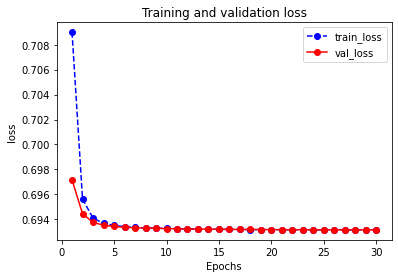

In [176]:
plot_metric(history, 'loss')

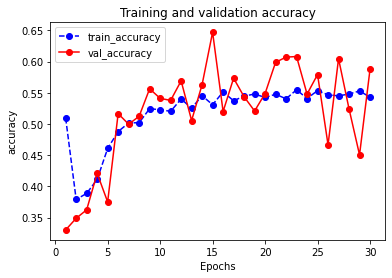

In [144]:
plot_metric(history, 'accuracy')

In [177]:
loss, accuracy = model.evaluate(x=X_test, y=y_test)
print("Loss: {:.2f}%".format(loss * 100))
print("Accuracy: {:.2f}%".format(accuracy * 100))

47/47 [==============================] - 0s 1ms/step - loss: 0.6932 - accuracy: 0.5650
Loss: 69.32%
Accuracy: 56.50%


In [178]:
y_prediction_array = model.predict(X_test)
y_prediction = np.argmax(y_prediction_array, axis=1)
y_prediction

array([1, 0, 1, ..., 1, 0, 0])

In [182]:
def metric_evaluation(y_test, y_pred):
    print("Metric Scores")
    print("==========================")
    print("Precision: {:.2f}%".format(precision_score(y_test, y_pred) * 100))
    print("Recall: {:.2f}%".format(recall_score(y_test, y_pred) * 100))
    print("F1: {:.2f}%".format(f1_score(y_test, y_pred) * 100))
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    return cm
    
confusion_matrix = metric_evaluation(y_test, y_prediction)

Metric Scores
Precision: 91.71%
Recall: 58.30%
F1: 71.29%

Confusion Matrix:
[[ 37  72]
 [570 797]]


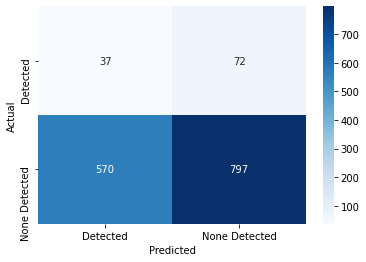

In [191]:
cm_df = pd.DataFrame(
    confusion_matrix, columns=['Detected', 'None Detected'], index=['Detected', 'None Detected']
)
ax = sns.heatmap(
    data=cm_df, cmap=cm.Blues, annot=True, fmt='d', linecolor='k'
)
ax.set(xlabel='Predicted', ylabel='Actual')
plt.show()